## Installs

On non-colab system, is usually good to make an environment and install necessary tools there. E.g., anaconda->jupyter->terminal create an environment, if you have not already, and activate it:
```
conda create -n adl python=3.9
conda activate adl
```
then install missing packages such as:
```
conda install ipykernel torch matplotlib torchmetrics scikit-image jpeg
conda install -c conda-forge segmentation-models-pytorch ipywidgets
```
and if you want to add it to jupyter's drop-down menu
```
ipython kernel install --user --name=adl
```
Now reload the jupyter-notebook's homepage and make a new or load an existing file. On colab, the tools have to be installed everytime

### Imports

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from methods.screener_methods import *

### Set global device

In [29]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cpu


### Main program

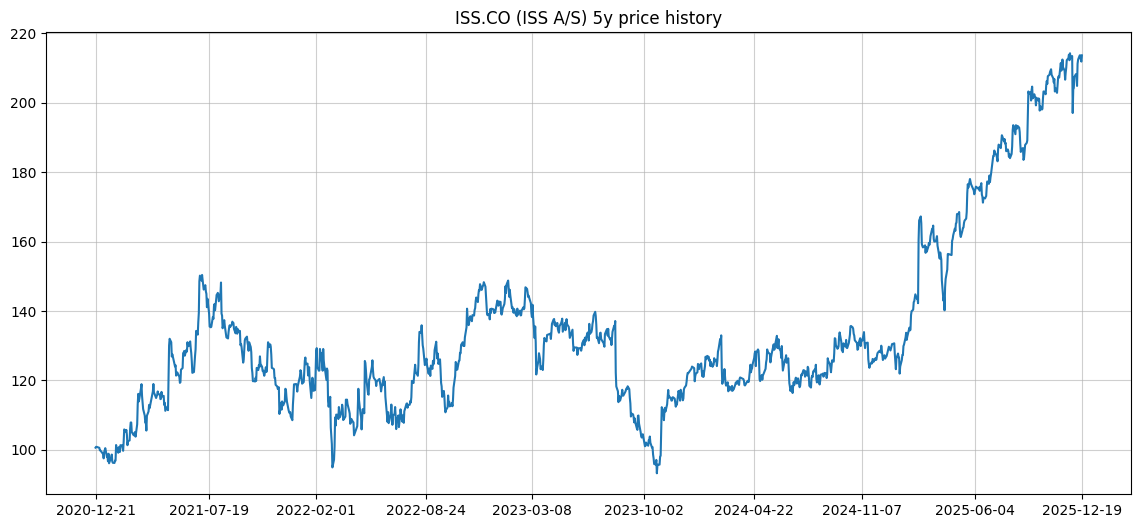

In [30]:
stock = Stock("ISS.CO")
period = "5y"
stock.price_graph(period)

In [31]:
# 1. Get Data
data = stock.price_history(period)
values = data.values.reshape(-1, 1)

# 2. Normalize
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(values)

# 3. Create Sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 10 # Use past 60 days to predict next day
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# 4. Convert to Tensors
X = torch.from_numpy(X).float().to(device)
y = torch.from_numpy(y).float().to(device)

# 5. Split Train/Test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: torch.Size([995, 10, 1]), Test shape: torch.Size([249, 10, 1])


In [32]:
# Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel().to(device)
print(model)

# Parameters
epochs = 100
lr = 0.01
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

print("Training finished.")

LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)
Epoch 0, Loss: 0.35979703068733215
Epoch 10, Loss: 0.028015142306685448
Epoch 20, Loss: 0.009675595909357071
Epoch 30, Loss: 0.004811044782400131
Epoch 40, Loss: 0.003943552728742361
Epoch 50, Loss: 0.0039231195114552975
Epoch 60, Loss: 0.003401160007342696
Epoch 70, Loss: 0.003150530159473419
Epoch 80, Loss: 0.002881685271859169
Epoch 90, Loss: 0.002667221939191222
Training finished.


Mean Squared Error (MSE): 317.1837
Root Mean Squared Error (RMSE): 17.8097
Mean Absolute Error (MAE): 14.5792


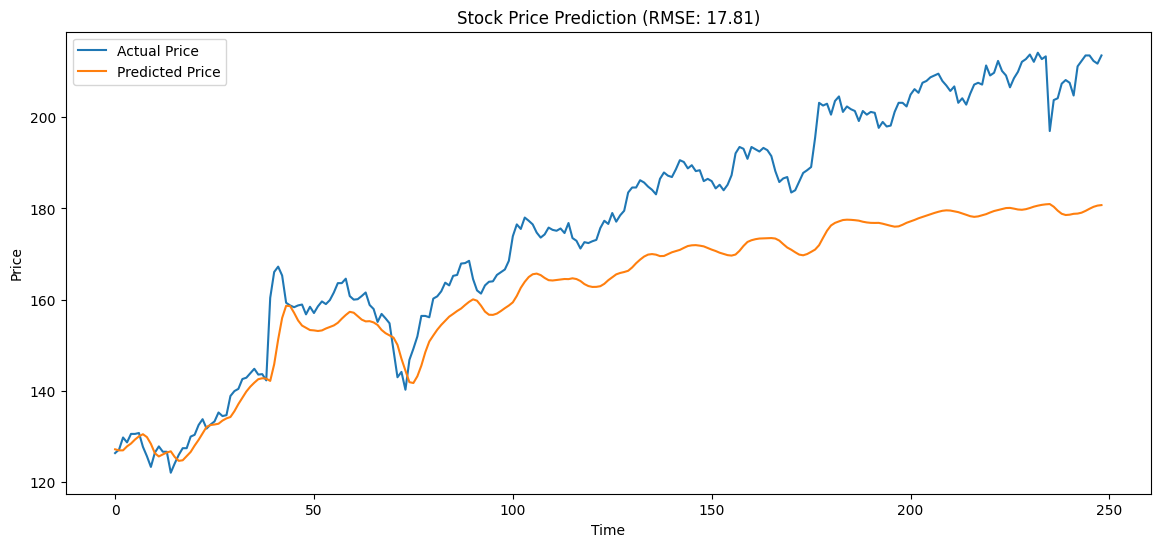

In [33]:
# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

model.eval()
with torch.no_grad():
    test_predictions = model(X_test)
    
    # Inverse transform predictions and actual values
    test_predictions = scaler.inverse_transform(test_predictions.cpu().numpy())
    y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())

# Calculate Metrics
mse = mean_squared_error(y_test_actual, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, test_predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Plot
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(test_predictions, label='Predicted Price')
plt.title(f'Stock Price Prediction (RMSE: {rmse:.2f})')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()